In [1]:
import numpy as np
import pandas as pd 

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# getting the data
trip = pd.read_csv('tripadvisor_hotel_reviews.csv')

In [3]:
trip.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
# Let's see if there is any null values in any column
trip.isnull().sum()

Review    0
Rating    0
dtype: int64

**No Null Values**

In [5]:
# Let's see if there is any empty string present in the review.If yes,we will go ahead and remove them
empty = []

for i,review,rating in trip.itertuples():
    if type(review) == str:
        if review.isspace():
            empty.append(i) # will take the index of that review
            
            
print(f"There are total {len(empty)} empty strings as review.")

There are total 0 empty strings as review.


**Great! There are no empty string present as rating**

In [6]:
# Let's check the different rating present
trip['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

Text(0, 0.5, 'Rating')

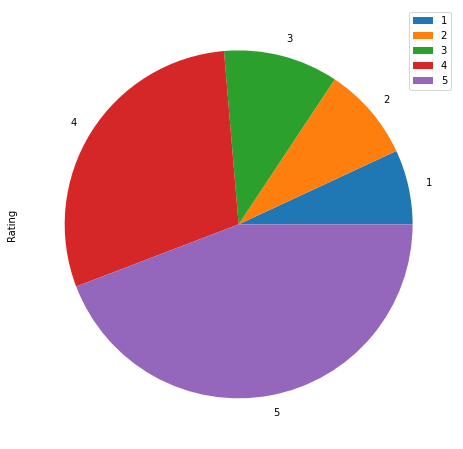

In [7]:
plt.figure(figsize=(12,8))
trip.groupby('Rating').size().plot(kind='pie',y='Rating',legend=True)
plt.ylabel('Rating')

The number of reviews with rating 5 is 9054 and combined reviews with 1 and 2 rating is (1793+1421) = 3214
If we create and train our model with this data it will be very week in predicting the correct rating.
It will get enough reviews with 5 rating to train on but will not get sufficient reviews to train for 1st or 2nd rating.

One workaround can be to modify the Rating column.We can take the reviews with rating 5 and call them Positive reviews and can combine the 1st rating and 2nd rating reviews and call them Negative reviews.We will ignore the reviews with 4th or 3rd rating.

In [8]:
# Let's create a new data frame
 
df = trip[(trip['Rating']==5)|(trip['Rating']==2)|(trip['Rating']==1)][['Review','Rating']]

# Lets modify the Rating column
df['Rating'] = df['Rating'].apply(lambda rating: 'Pos' if rating==5 else 'Neg')

In [9]:
df.head()

,Review,Rating
1,ok nothing special charge diamond member hilto...,Neg
3,"unique, great stay, wonderful time hotel monac...",Pos
4,"great stay great stay, went seahawk game aweso...",Pos
5,love monaco staff husband stayed hotel crazy w...,Pos
6,"cozy stay rainy city, husband spent 7 nights m...",Pos


**We will use the new dataframe df to create and train our model.**

In [11]:
# Let's assign the Id to all the unique words present in Tokens columns
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

tokenizer.fit_on_texts(df['Review'])

In [12]:
# Let's see total number of unique words present in all the reveiws combined
vocab_size = len(tokenizer.index_word)

# tokeninzer.index_word is a dictonary which can be user to view all the unique words and there ID's.

print(f'There are total {vocab_size} unique words present')

There are total 40352 unique words present


In [13]:
# Now let's replace each word in review with there respective token id
sequences = tokenizer.texts_to_sequences(df['Review'])

In [14]:
tokenizer.index_word

{1: 'hotel',
 2: 'room',
 3: 'not',
 4: 'great',
 5: "n't",
 6: 'staff',
 7: 'stay',
 8: 'good',
 9: 'did',
 10: 'just',
 11: 'rooms',
 12: 'no',
 13: 'service',
 14: 'stayed',
 15: 'nice',
 16: 'location',
 17: 'time',
 18: 'day',
 19: 'night',
 20: 'breakfast',
 21: 'food',
 22: 'beach',
 23: 'clean',
 24: 'like',
 25: 'place',
 26: 'resort',
 27: 'really',
 28: 'the',
 29: 'pool',
 30: 'excellent',
 31: 'friendly',
 32: '2',
 33: 'people',
 34: 'best',
 35: 'got',
 36: 'helpful',
 37: 'walk',
 38: 'small',
 39: 'area',
 40: '5',
 41: 'little',
 42: 'trip',
 43: '3',
 44: 'bar',
 45: 'recommend',
 46: 'bed',
 47: 'wonderful',
 48: 'restaurant',
 49: 'beautiful',
 50: 'bathroom',
 51: 'went',
 52: 'restaurants',
 53: 'desk',
 54: 'water',
 55: 'view',
 56: 'floor',
 57: 'hotels',
 58: 'way',
 59: 'check',
 60: 'nights',
 61: 'comfortable',
 62: 'make',
 63: 'away',
 64: 'booked',
 65: 'city',
 66: 'better',
 67: 'free',
 68: 'right',
 69: '4',
 70: 'want',
 71: 'say',
 72: 'reviews',


In [15]:
# Now to create a RNN-NLP model,each input should be equal in length
# we can acheciving by padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

# We will keep the length of inputs to be 100.So if any input have length less then 100,extra 0s will be added
# Any input with length more then 100 will have the extra word removed.
sequences_padded = pad_sequences(sequences,maxlen=100,padding='post')


In [16]:
sequences_padded # input data

array([[  292,  2208,     1, ...,   932,    57,   582],
       [ 1228,     4,     7, ...,     0,     0,     0],
       [20650,     4,    37, ...,  3796,     5,   373],
       ...,
       [  231,    10,   792, ...,     0,     0,     0],
       [ 1642,  1297,   640, ...,   267,  4930,  4259],
       [   33,  1113,   173, ...,     0,     0,     0]])

In [17]:
# Now our input variable is in correct format to create and train our model
# Let's check the output variable
df['Rating'].unique()

array(['Neg', 'Pos'], dtype=object)

In [19]:
# We can replace the Pos with 1 and Neg with 0
y = np.array(df['Rating'].apply(lambda rating: 1 if rating == 'Pos' else 0))

y

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [20]:
# Our input and out put varibales are ready.Let's split the data into train set and test set
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(sequences_padded,y,test_size=0.2)

In [21]:
# Libraries to create and train our model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding

In [22]:
# Model
max_len = 100 # length of each input
embedding_size = 32

model = Sequential()

model.add(Embedding(vocab_size+1,embedding_size,input_length = max_len))

model.add(LSTM(150,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(150))
model.add(Dropout(0.2))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))

model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           1291296   
_________________________________________________________________
lstm (LSTM)                  (None, 100, 150)          109800    
_________________________________________________________________
dropout (Dropout)            (None, 100, 150)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               38656     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

In [25]:
# Let's train our model
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=15,batch_size=64)

Epoch 1/15
154/154 [==============================] - 86s 559ms/step - loss: 0.4045 - accuracy: 0.7409 - val_loss: 0.4414 - val_accuracy: 0.7274
Epoch 2/15
154/154 [==============================] - 88s 570ms/step - loss: 0.3863 - accuracy: 0.7592 - val_loss: 0.4413 - val_accuracy: 0.7274
Epoch 3/15
154/154 [==============================] - 87s 564ms/step - loss: 0.3980 - accuracy: 0.7419 - val_loss: 0.4333 - val_accuracy: 0.7278
Epoch 4/15
154/154 [==============================] - 87s 562ms/step - loss: 0.3778 - accuracy: 0.7680 - val_loss: 0.3524 - val_accuracy: 0.8720
Epoch 5/15
154/154 [==============================] - 86s 560ms/step - loss: 0.1409 - accuracy: 0.9599 - val_loss: 0.2670 - val_accuracy: 0.8843
Epoch 6/15
154/154 [==============================] - 88s 573ms/step - loss: 0.1106 - accuracy: 0.9696 - val_loss: 0.2902 - val_accuracy: 0.9014
Epoch 7/15
154/154 [==============================] - 86s 561ms/step - loss: 0.1478 - accuracy: 0.9576 - val_loss: 0.2648 - val_ac

In [26]:
metrics = pd.DataFrame(model.history.history)

metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,0.404472,0.740880,0.441439,0.727384
1,0.386284,0.759221,0.441258,0.727384
2,0.397968,0.741899,0.433347,0.727791
3,0.377781,0.767985,0.352388,0.872046
4,0.140857,0.959853,0.267016,0.884271


<AxesSubplot:>

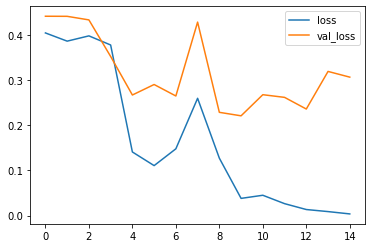

In [27]:
metrics[['loss','val_loss']].plot()

<AxesSubplot:>

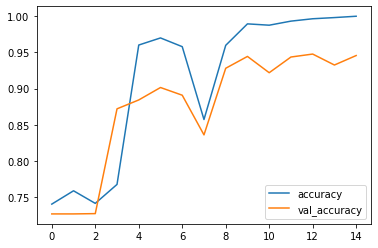

In [28]:
metrics[['accuracy','val_accuracy']].plot()

In [41]:
# Let's predict on few reviews
neg_review = ['Rooms were old. Staff difficult to reach. Food bad. Loud room parties. Kid based place. No concierge room available. Pick another hotel. This is definitely on a low level with little interest in higher']

# This is a negative review.Let's check if the model is able to predict it

In [42]:
# Let's tokenize it and do the pad_sequence to make it in right format acceptable by model
neg_review_token = tokenizer.texts_to_sequences(neg_review)

# padding
neg_review_padded = pad_sequences(neg_review_token,maxlen=100,padding='post')

In [43]:
review_predict = (model.predict(neg_review_padded)>0.5).astype('int32')

In [44]:
# 1 is Positive review and 0 is negative review
if review_predict[0] == 0:
    print("It's a negative review")
else:
    print("It's a positive review")

It's a negative review


In [46]:
# Let's try another one.This time we will take a positive review
pos_review = ["Very good sized room with decent facilities which had triple glazing - needed as facing the church bells! Some of the rooms can have a few short flights of stairs even after using the lift so you may need to check when booking that any mobility needs are met. Good buffet breakfast"]
# Tokenization
pos_review = tokenizer.texts_to_sequences(pos_review)

# padding
pos_review = pad_sequences(pos_review,maxlen=100,padding='post')

# prediction
review_predict1 = (model.predict(pos_review)>0.5).astype('int')

if review_predict1[0] == 0:
    print("It's a negative review")
else:
    print("It's a positive review")

It's a positive review


In [34]:
# Let's predict on X_test
prediction = (model.predict(X_test)>0.5).astype('int32')

In [35]:
# Evaluation
from sklearn.metrics import classification_report

In [36]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       669
           1       0.95      0.97      0.96      1785

    accuracy                           0.95      2454
   macro avg       0.94      0.92      0.93      2454
weighted avg       0.94      0.95      0.94      2454



# Model Accuracy on test data - 95%

In [47]:
# Let's save the model
model.save('review.h5')

In [48]:
# Let's save the tokenizer
import pickle

In [50]:
pickle.dump(tokenizer,open('tokenizer.pkl','wb'))

# Thank you